In [74]:
from pathlib import Path 
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
data = "../data/data.yaml"


In [3]:
train_path = "../data/train"
val_path = "../data/valid"
test_path = "../data/test"

train_images = train_path + "/images"
val_images = val_path + "/images"
test_images = test_path + "/images"

train_labels = train_path + "/labels"
val_labels = val_path + "/labels"
test_labels = test_path + "/labels"




In [4]:
classes = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
idx_to_class = {i : k for i,k in enumerate(classes)}
class_to_idx = {k: i for i, k in idx_to_class.items()}


In [5]:
class_to_idx

{'fish': 0,
 'jellyfish': 1,
 'penguin': 2,
 'puffin': 3,
 'shark': 4,
 'starfish': 5,
 'stingray': 6}

In [6]:
class_to_idx

{'fish': 0,
 'jellyfish': 1,
 'penguin': 2,
 'puffin': 3,
 'shark': 4,
 'starfish': 5,
 'stingray': 6}

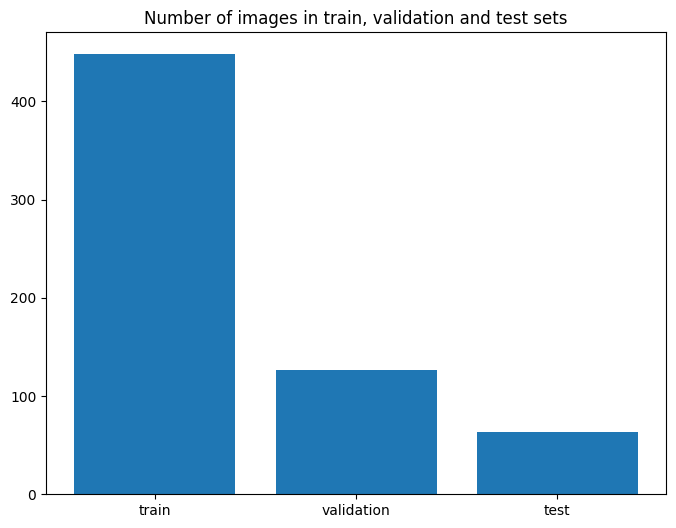

In [7]:
def plot_data(data: dict, title : str):
    plt.figure(figsize = (8,6))
    plt.bar(data.keys(), data.values())
    plt.title("Number of images in train, validation and test sets")
    plt.show()
    
def get_num_images(path):
    return len(os.listdir(path))

plot_data(data = {'train': get_num_images(train_images), "validation" : get_num_images(val_images), "test" : get_num_images(test_images)}, title = 
          "Number of images in train, test and val splits")  
    

In [8]:
def count_obj_per_split(image_dir, label_dir):
    object_count = {}
    total_object_count = []
    img_files = sorted(os.listdir(image_dir))
    for file in img_files: 
        label_path = os.path.join(label_dir,  file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        total_object_count.append(len(lines))
        for line in lines: 
            object_count[(idx_to_class[int(line.split()[0])])] = object_count.get(idx_to_class[int(line.split()[0])], 0) + 1
        f.close()
    return object_count, total_object_count    



In [9]:
object_counts_train, total_train_objects = count_obj_per_split(train_images, train_labels)
object_counts_val, total_val_objects = count_obj_per_split(val_images, val_labels)
object_counts_test, total_test_objects = count_obj_per_split(test_images, test_labels)

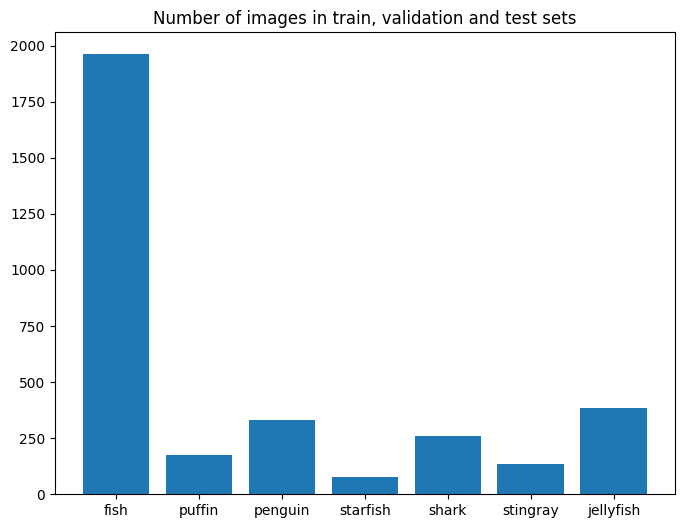

In [10]:
plot_data(object_counts_train, title = "Total instances of each class in training set")

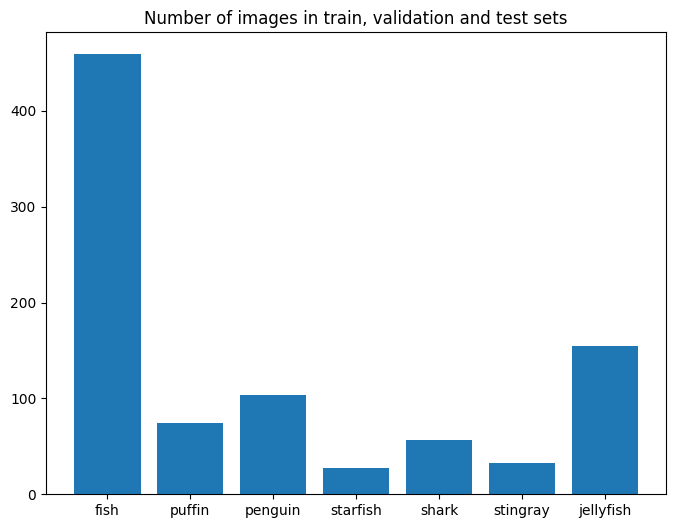

In [11]:
plot_data(object_counts_val, title = "Total instances of each class in validation set")

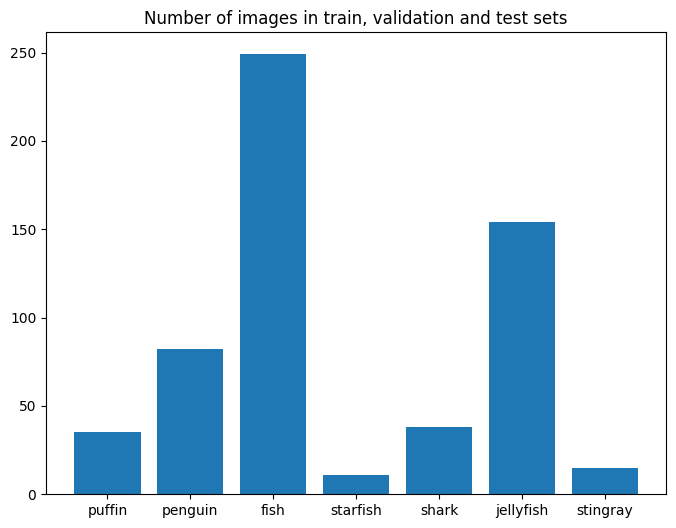

In [12]:
plot_data(object_counts_test, title = "Total instances of each class in test set")

Now we can consider the number of objects per image and visualise this in a histogram 

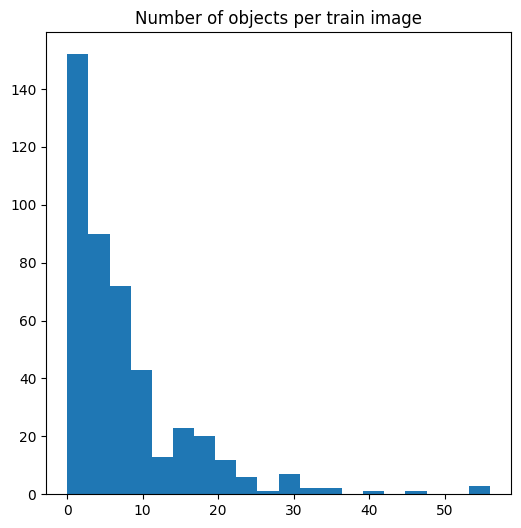

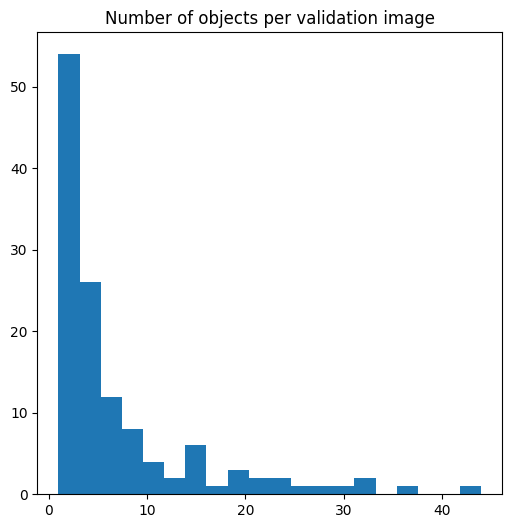

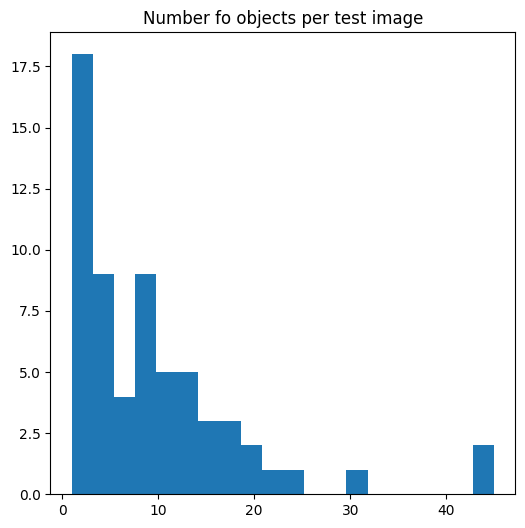

In [13]:
def plot_hist(x_var : list, title:str, bins: int = 20):
    plt.figure(figsize = (6,6))
    plt.hist(x = x_var, bins = bins)
    plt.title(title)
    plt.show()

plot_hist(total_train_objects, "Number of objects per train image")
plot_hist(total_val_objects, "Number of objects per validation image")
plot_hist(total_test_objects, "Number fo objects per test image")

Now,we can also visualise the bounding box sizes on average in the training, test and validation sets. 

In [14]:
def bounding_box_sizes(image_dir, label_dir):
    sizes = []
    image_files = sorted(os.listdir(image_dir))
    for image in image_files:
        label_path = os.path.join(label_dir, image[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        for line in lines: 
            sizes.append(float(line.split()[3]) * float(line.split()[4]))
        f.close()

    return sizes    

In [15]:
train_sizes = bounding_box_sizes(train_images, train_labels)
val_sizes = bounding_box_sizes(val_images, val_labels)
test_sizes = bounding_box_sizes(test_images, test_labels)

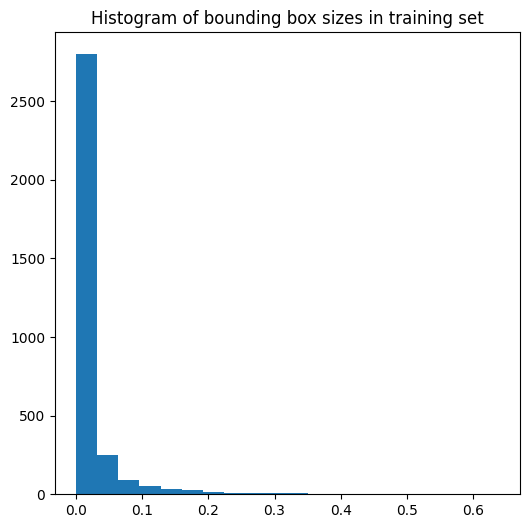

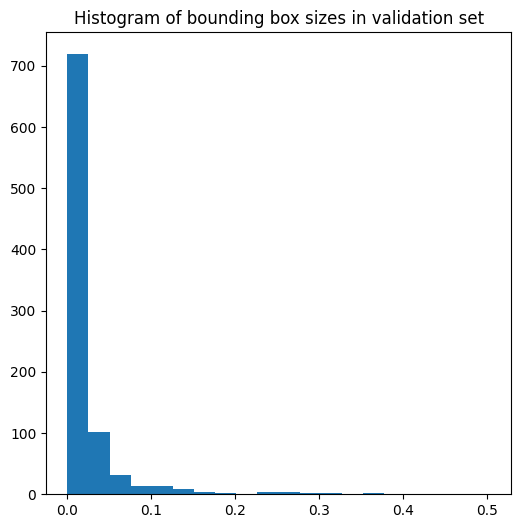

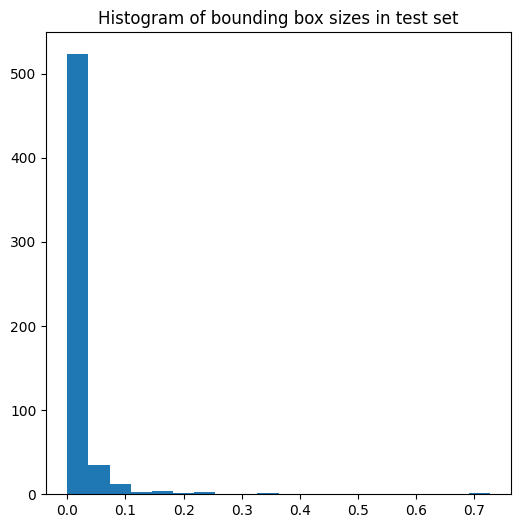

In [16]:
plot_hist(train_sizes, title = "Histogram of bounding box sizes in training set")
plot_hist(val_sizes, "Histogram of bounding box sizes in validation set")
plot_hist(test_sizes, "Histogram of bounding box sizes in test set")

In [39]:
def images_with_bbox_annots(image_dir, label_dir):
    image_files = sorted(os.listdir(image_dir))

    sample_images = random.sample(image_files, 12)

    fig, axs = plt.subplots(4,3, figsize = (15,20))

    for i, image in enumerate(sample_images):
        image_path = os.path.join(image_dir, image)
        label_path = os.path.join(label_dir, image[:-4] + ".txt")
        f = open(label_path)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        for line in f: 
            class_id, x_center, y_center, width, height = map(float, line.split())
            h, w, _ = image.shape
            x_min = int((x_center - width / 2) * w)
            y_min = int((y_center - height / 2) * h)
            x_max = int((x_center + width / 2) * w)
            y_max = int((y_center + height / 2) * h)

            cv2.rectangle(image, (x_min,y_min), (x_max, y_max), (255,0,0), 2)
            cv2.putText(image, idx_to_class[int(class_id)],
                        (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale = 1, color = (255,255,255), thickness = 3)
        row = i // 3
        col = i % 3    
            
        axs[row, col].imshow(image)
        axs[row, col].axis("off")
    plt.show()    
        

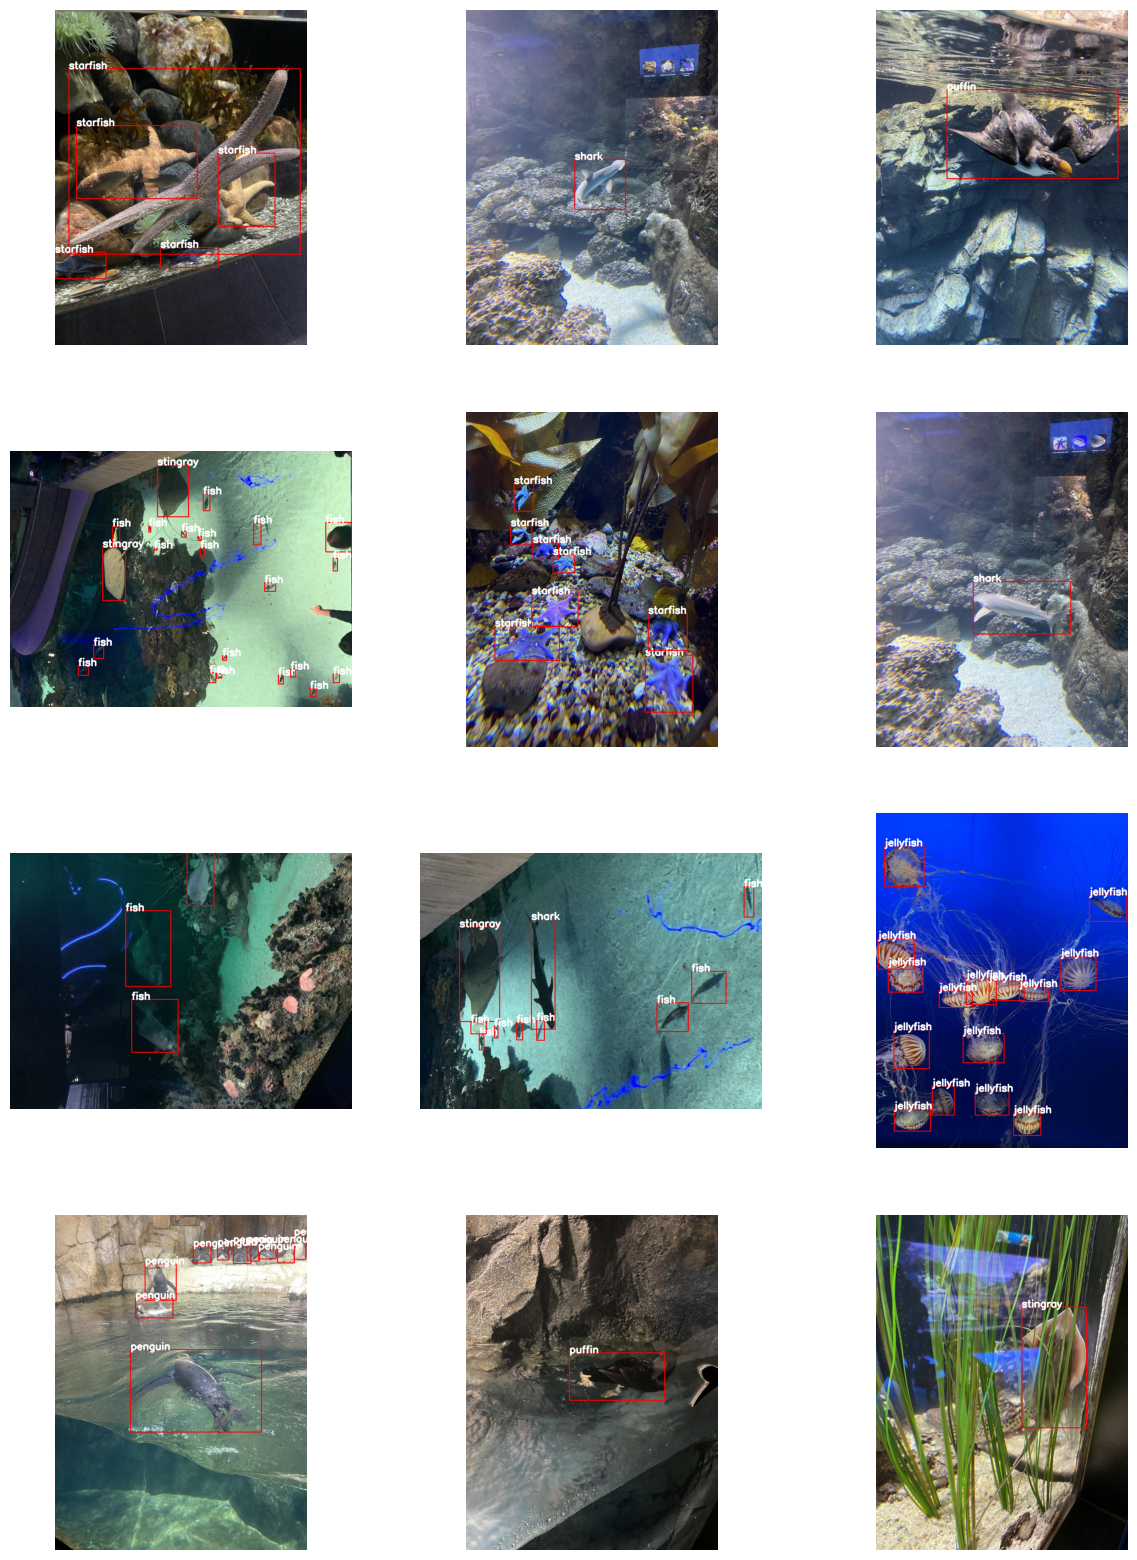

In [40]:
images_with_bbox_annots(train_images, train_labels)

Now it's time for preprocessing. This is done to make sure that the images are in the format expected by the RCNN models. First order of action is to resize the images. A function is defined which resizes images to (640, 640) if the images are square, and otherwise rescales the image while maintaining aspect ratio. 

In [43]:
def resize(image, img_size = 640, square = False):
    if square: 
        image = cv2.resize(image, (img_size, img_size))
    else: 
        h, w = image.shape[:2]
        r = img_size/max(h,w)
        image = cv2.resize(image, (int(h * r), int(w * r)))
    return image    



In [66]:
DESTINATION_PATH = "../preprocessed_data"

TRAIN_DESTINATION = DESTINATION_PATH + "/train"
VAL_DESTINATION = DESTINATION_PATH + "/valid"
TEST_DESTINATION = DESTINATION_PATH + "/test"

train_img_dest = TRAIN_DESTINATION + "/images"
train_label_dest = TRAIN_DESTINATION + "/labels"

val_img_dest = VAL_DESTINATION + "/images"
val_label_dest = VAL_DESTINATION + "/labels"

test_img_dest = TEST_DESTINATION + "/images"
test_label_dest = TEST_DESTINATION + "/labels"

In [70]:
os.makedirs(train_label_dest, exist_ok=True)
os.makedirs(train_img_dest, exist_ok=True)
os.makedirs(val_label_dest, exist_ok=True)
os.makedirs(val_img_dest, exist_ok=True)
os.makedirs(test_label_dest, exist_ok=True)
os.makedirs(test_img_dest, exist_ok=True)

Next it is time to resize the images. It is considered best practice not to overwrite the images in the dataset and thus we will save them to the destination paths given above. 

In [71]:
def resize_new_loc(image_dir, label_dir, image_dest, label_dest, img_size=640, square=False):
    image_files = sorted(os.listdir(image_dir))
    for file in image_files:
        image_path = os.path.join(image_dir, file)
        image = resize(cv2.imread(image_path), img_size=img_size, square=square)
        cv2.imwrite(os.path.join(image_dest, file), image)
        
        label_path = os.path.join(label_dir, file[:-4] + ".txt")
        f = open(label_path)
        lines = f.readlines()
        f.close()
        
        f = open(os.path.join(label_dest, file[:-4] + ".txt"), "w")
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.split())
            h, w, _ = image.shape
            x_center *= w
            y_center *= h
            width *= w
            height *= h
            f.write("{} {} {} {} {}\n".format(int(class_id), x_center, y_center, width, height))
        f.close() 

In [72]:
resize_new_loc(train_images, train_labels, train_img_dest, train_label_dest)
resize_new_loc(val_images, val_labels, val_img_dest, val_label_dest)
resize_new_loc(test_images, test_labels, test_img_dest, test_label_dest)

### Data Augmentations
Data Augmentations are an integral part of training image based models as they improve the generalisation of the models by showing the same images in different forms. Some common augmentations that we are going to include are RandomHorizontalFlip which randomly flips an image horizontally, RandomVerticalFlip which flips an image vertically, RandomRotation that rotates an iamge by a given angle. In addition to this, ColorJitter is also used which randomly changes hue, contrast or brightness of an image. 

In [ ]:
def train_augs():
    return A.Compose(
        [
            A.OneOf(
                [
                    A.Blur(blur_limit=3, p=0.5),
                    A.MotionBlur(blur_limit=3, p=0.5),
                    A.MedianBlur(blur_limit=3, p=0.5),
                ],
                p=0.5,
            ),
            A.ToGray(p=0.1),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            A.RandomGamma(p = 0.1), 
            A.RandomRotate90(p = 0.5), 
            A.HorizontalFlip(p = 0.5), 
            A.VerticalFlip(p = 0.5), 
            ToTensorV2(p = 1.0)
        ], 
        bbox_params = A.BboxParams(format = 'coco', label_fields= ["labels"]), 
    )

In [75]:
def train_transforms():
    return A.Compose(
        [
            ToTensorV2(p = 1.0)
        ],
        bbox_params= A.BboxParams(format = 'coco', label_fields= ["labels"])
    )

In [76]:
def get_valid_transform():
    return A.Compose(
        [
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format="coco",
            label_fields=["labels"],
        ),
    )